# Stardard NN su database MNIST

Neural network sviluppata in TensorFlow versione 1.x, su database MNIST.

In [52]:
%tensorflow_version 1.x

In [53]:
#Import per interoperabilità python 2-3
#from __future__ import division

In [54]:
import tensorflow as tf
from tensorflow import keras as ks

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize

import cv2

#Data visualization
import seaborn as sns

from matplotlib import pyplot as plt

import glob
import os, os.path

#Per modello NN
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Dropout

import time
import math

print(tf.__version__)

1.15.2


##Definizione metodi

In [55]:
#Extract the class from the file name, if the class is the string before che -
def extract_label(from_string):
  position = from_string.index('-') # gets position of the - in the filename
  substring = from_string[0:position]
  return substring

def extract_obf(from_string):
  start_pos = from_string.index('-')
  end_pos = from_string.index('.')
  substring = from_string[(start_pos + 1):end_pos]
  return substring

def mapping_labels_encoded(label_encoder):
  for index in range(len(list(label_encoder.classes_))):
    print(index, end = "-> ")
    print(list(label_encoder.inverse_transform([index]))) 

class TimeHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


print("Done")

Done


#Import del dataset
Import del dataset, e stampa della sua struttura.

In [56]:
#Import del database MNIST
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#Struttura dati nel database
print("Numero elementi e dimensione immagini in train set: " + str(train_images.shape))
print("Numero elementi e dimensione immagini in test set: " + str(test_images.shape))
print("Numero elementi label in train set: " + str(len(train_labels)))
print("Numero elementi label in test set: " + str(len(test_labels)))
print("Tipo di struttura del train set: " + str(type(train_images)) + ", composto da " + str(type(train_images[0])))
print("Tipo di struttura del label set: " + str(type(train_labels)) + ", composto da " + str(type(train_labels[0])))
print("Le etichette sono interi; valore più piccolo: " + str(np.amin(train_labels)) + ", valore più grande: " + str(np.amax(train_labels)))

Numero elementi e dimensione immagini in train set: (60000, 28, 28)
Numero elementi e dimensione immagini in test set: (10000, 28, 28)
Numero elementi label in train set: 60000
Numero elementi label in test set: 10000
Tipo di struttura del train set: <class 'numpy.ndarray'>, composto da <class 'numpy.ndarray'>
Tipo di struttura del label set: <class 'numpy.ndarray'>, composto da <class 'numpy.uint8'>
Le etichette sono interi; valore più piccolo: 0, valore più grande: 9


##Struttura del database

Il database è diviso in training set e testing set.

Nel training set ci sono 60k immagini 28x28, e 60k etichette.

Nel test set ci sono 10k immagini 28x28 e 10k etichette.

L'immagine è formata da valori che variano da 0 a 255, e le etichette sono un intero tra 0 e 9.


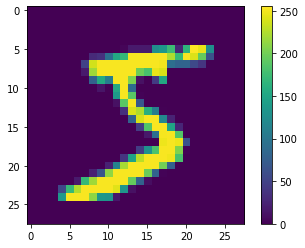

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [57]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

#L'etichetta è un intero tra 0 e 9
train_labels

##Preprocessing dei dati
Scalo tutte le immagini nel range tra 0 e 1.

In [58]:
#Preprocessing dei dati
#Scalo i valori nel range tra 0 e 1
train_images = train_images / 255.0

test_images = test_images / 255.0

print("Done")

Done


La normalizzazione così fatta fa un cast a float64 di default; possiamo ottimizzare lo spazio di memoria facendo un cast a float32.

In [59]:
type(train_images[0][0][0])

numpy.float64

In [60]:
dim1, dim2 = train_images[0].shape

In [61]:
#Dopo la normalizzazione, va rifatto il cast
train_images = train_images.reshape(-1, dim1, dim2).astype(np.single)
test_images = test_images.reshape(-1, dim1, dim2).astype(np.single)

In [62]:
type(train_images[0][0][0])

numpy.float32

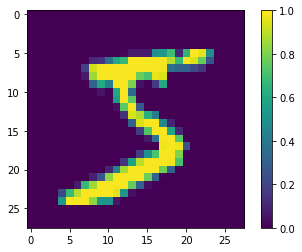

In [63]:
#Controllo lo scaling dei dati
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Guardo un piccolo insieme di immagini con etichette corrispondenti assegnate.

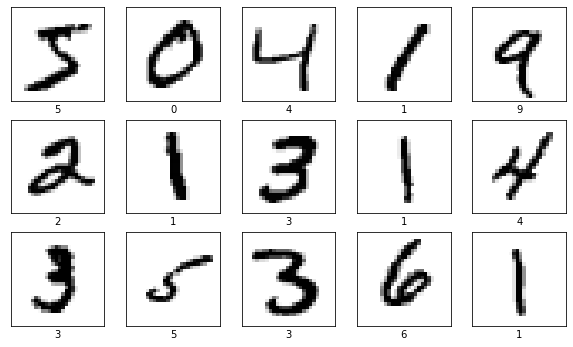

In [64]:
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

#Costruzione modello
Vado a costruire il modello.

Il primo layer del network, *tf.keras.layers.Flatten*, trasforma il formato delle immagini da un array bidimensionale ad un array monodimensionale (28x28 px -> 28*28=784 px).

Questo *layer* non ha parametri da imparare, è solo una manipolazione dei dati.

Dopo il *flattening* dei pixel, la network consiste di una sequenza di due layer *tf.keras.layers.Dense*. Questi sono neural layers "densamente" connessi, o pienamente connessi. Il primo layer *Dense* ha 256 nodi; il secondo layer ha 128 nodi, e l'ultimo layer è un 10-node *softmax* layer che ritorna un array di 10 *probability scores* che sommano a 1. Ogni nodo contiene un punteggio che indica con che probabilità l'immagine corrente appartiene ad una delle 10 classi.

**Compilare il modello**

Sono necessari alcuni settings prima di completare il modello. Questi sono aggiunti durante la fase *compile*:
* *Loss function* — Misura quanto accurato è il modello durante il training. Si vuole minimizzare la funzione affinchè "viri" nella direzione giusta.
* *Optimizer* — è il modo in cui il modello è aggiornato basandosi sui dati che vede e la loss function.
* *Metrics* — Usata per monitorare la fase di training e di testing. Il seguente esempio usa l'*accuracy*, la frazione delle immagini che sono correttamente classificate.

##Build

In [65]:
keras_model = ks.models.Sequential()
keras_model.add(ks.layers.Flatten(input_shape=(28, 28)))
keras_model.add(ks.layers.Dense(256, activation = 'relu'))
keras_model.add(ks.layers.Dense(128, activation = 'relu'))
keras_model.add(ks.layers.Dense(10, activation = 'softmax'))

print("Done")

Done


##Compile

In [66]:
keras_model.compile(optimizer = 'adam', 
                    loss = 'sparse_categorical_crossentropy', 
                    metrics = ['accuracy'])

print(keras_model.summary())

print("Done")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
None
Done


##Traning del modello

Training diviso in step:
1. Passare ("feeding") il training data al modello. Nell'esempio, il training data sono  gli array `train_images` e `train_labels`.
2. Il modello impara ad associare immagini e labels.
3. Si chiede al modello di fare predizioni su un test set; in questo esempio, l'array `test_images`. Verifica che le previsioni corrispondano alle labels dall'array `test_labels`.

Per iniziare il training, chiamiamo il metodo `model.fit`; chiamato così perchè "fits" il modello al training data.

Passando in `model.fit` anche `validation_data`, il modello calcolerà la funzione di *accuray* e di *loss* anche rispetto ai dati di valutazione, ossia il test set.

In [67]:
time_callback = TimeHistory()
es = ks.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                mode='auto', restore_best_weights=True, verbose=1)

history = keras_model.fit(train_images, train_labels, validation_data=(test_images, test_labels),
                          epochs=10, callbacks=[time_callback, es])

print("Done")

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 94us/sample - loss: 0.2080 - acc: 0.9379 - val_loss: 0.0988 - val_acc: 0.9696
Epoch 2/10
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0858 - acc: 0.9732 - val_loss: 0.0870 - val_acc: 0.9724
Epoch 3/10
60000/60000 [==============================] - 6s 97us/sample - loss: 0.0595 - acc: 0.9814 - val_loss: 0.0972 - val_acc: 0.9701
Epoch 4/10
60000/60000 [==============================] - 6s 96us/sample - loss: 0.0445 - acc: 0.9860 - val_loss: 0.0724 - val_acc: 0.9786
Epoch 5/10
60000/60000 [==============================] - 6s 95us/sample - loss: 0.0345 - acc: 0.9888 - val_loss: 0.0790 - val_acc: 0.9779
Epoch 6/10
60000/60000 [==============================] - 6s 96us/sample - loss: 0.0267 - acc: 0.9911 - val_loss: 0.0928 - val_acc: 0.9761
Epoch 7/10
60000/60000 [==============================] - 6s 97us/sample - loss: 0.0248 - acc: 0.9919 - val_loss: 0.

##Accuratezza

Dopo aver allenato il modello, ho una prima misura di accuratezza.

Questa non è un indicatore valido per indicare quanto la rete neurale abbia imparato, in quanto le predizioni di classificazione sono fatte su un set finito con labels già assegnate. Questo effetto è detto **overfitting**.

Utilizzo una porzione di dati non utilizzata nel training per misurare la precisione reale.

In [68]:
#Misuro accuratezza
test_accuracy = keras_model.evaluate(test_images, test_labels)

print("Accuratezza: " + str(test_accuracy))

print("Time per epoch: " + str(time_callback.times))
total_time = time_callback.times
total_time_str = sum(total_time)
print("Total time: " + str(total_time_str))

print("Done")

10000/10000 [==============================] - 0s 38us/sample - loss: 0.0724 - acc: 0.9786
Accuratezza: [0.07244958518927451, 0.9786]
Time per epoch: [5.6318519115448, 5.5668251514434814, 5.7930169105529785, 5.772881031036377, 5.711755275726318, 5.7809693813323975, 5.814083814620972, 5.685865640640259, 5.667421102523804]
Total time: 51.42467021942139
Done


In [69]:
#history_dict = history.history
#print(history_dict.keys())

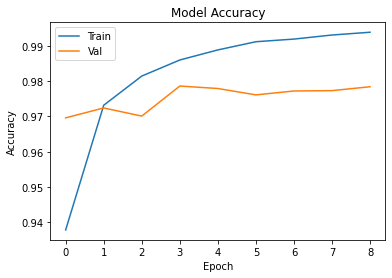

Time per epoch: [5.6318519115448, 5.5668251514434814, 5.7930169105529785, 5.772881031036377, 5.711755275726318, 5.7809693813323975, 5.814083814620972, 5.685865640640259, 5.667421102523804]
Total time: 51.42467021942139


In [70]:
#Visualize the models accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

print("Time per epoch: " + str(time_callback.times))
total_time = time_callback.times
total_time_str = sum(total_time)
print("Total time: " + str(total_time_str))

Difatti, la percentuale di accuratezza mostrata nel training è del 99,51%, che diventa del 97,99% se misurata sul test set.

##Analizzo i risultati errati

In [71]:
incorrects = np.nonzero(keras_model.predict_classes(test_images).reshape((-1,)) != test_labels)

In [72]:
print(incorrects)

(array([  62,  104,  247,  274,  290,  321,  340,  381,  445,  495,  551,
        582,  610,  619,  659,  689,  716,  720,  740,  881,  947,  959,
        965, 1014, 1039, 1112, 1156, 1181, 1182, 1226, 1247, 1260, 1315,
       1319, 1325, 1328, 1393, 1395, 1425, 1438, 1494, 1522, 1530, 1531,
       1549, 1581, 1609, 1621, 1642, 1681, 1754, 1790, 1850, 1901, 1938,
       1941, 1984, 2004, 2018, 2024, 2035, 2043, 2070, 2093, 2109, 2129,
       2130, 2135, 2182, 2185, 2189, 2280, 2293, 2299, 2408, 2454, 2462,
       2488, 2582, 2607, 2648, 2654, 2730, 2770, 2771, 2810, 2863, 2877,
       2915, 2921, 2927, 2939, 2952, 2953, 2995, 3030, 3060, 3073, 3117,
       3405, 3441, 3490, 3503, 3520, 3525, 3549, 3558, 3604, 3635, 3664,
       3767, 3780, 3808, 3811, 3818, 3838, 3869, 3893, 3906, 3941, 3943,
       4065, 4078, 4093, 4154, 4156, 4163, 4176, 4199, 4238, 4248, 4269,
       4289, 4294, 4356, 4363, 4400, 4487, 4536, 4548, 4571, 4639, 4690,
       4723, 4740, 4807, 4823, 4837, 4880, 4956, 4

In [73]:
temp_incorrects = list()
for elem in incorrects[0]:
  #print(elem)
  temp_incorrects.append(elem)
incorrects = temp_incorrects

In [74]:
wrong_labels = list()
for elem in incorrects:
  etichetta_errata = test_labels[elem]
  wrong_labels.append(etichetta_errata)
  #print(etichetta_errata)

In [75]:
print(wrong_labels)

[9, 9, 4, 9, 8, 2, 5, 3, 6, 8, 7, 8, 4, 1, 2, 7, 1, 5, 4, 4, 8, 4, 6, 6, 7, 4, 7, 6, 6, 7, 9, 7, 3, 8, 8, 7, 5, 2, 8, 0, 7, 7, 8, 3, 4, 7, 2, 0, 2, 3, 7, 2, 8, 9, 4, 7, 2, 8, 1, 7, 5, 4, 7, 8, 3, 9, 4, 6, 1, 0, 9, 3, 9, 2, 3, 6, 2, 2, 9, 7, 9, 6, 7, 3, 4, 5, 9, 4, 7, 3, 3, 9, 3, 3, 6, 6, 9, 1, 5, 4, 7, 4, 9, 6, 7, 3, 5, 7, 8, 9, 7, 4, 7, 2, 0, 7, 9, 5, 1, 4, 3, 0, 9, 9, 9, 2, 9, 2, 7, 7, 2, 4, 2, 9, 5, 9, 7, 7, 6, 5, 6, 8, 7, 2, 3, 8, 9, 7, 0, 8, 8, 7, 1, 1, 7, 4, 9, 4, 5, 3, 3, 3, 3, 3, 7, 3, 3, 2, 0, 6, 9, 1, 7, 0, 8, 0, 8, 1, 6, 0, 4, 4, 1, 7, 7, 0, 8, 9, 5, 7, 4, 4, 5, 7, 7, 7, 8, 8, 9, 0, 2, 4, 6, 2, 5, 4, 5, 2, 5, 4, 9, 2, 6, 5]


In [76]:
from collections import Counter

conto = Counter(wrong_labels)

In [77]:
print(conto)

Counter({7: 39, 9: 28, 4: 26, 3: 22, 8: 21, 2: 21, 5: 17, 6: 17, 0: 12, 1: 11})


In [78]:
type(conto)

collections.Counter

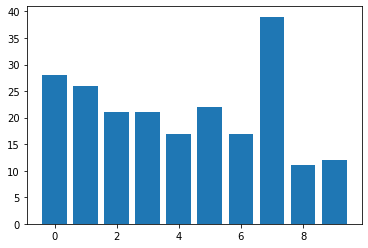

In [79]:
plt.bar(range(len(conto)), conto.values())
plt.show()

##Matrice di confusione

Genero la matrice di confusione sul test set.

In [80]:
#Necessito di un array con tutte le labels
classes=[0,1,2,3,4,5,6,7,8,9]

test_predictions = keras_model.predict_classes(test_images)

conf_matr = confusion_matrix(y_true = test_labels, y_pred = test_predictions)
print(conf_matr)

con_mat_norm = np.around(conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = classes, 
                          columns = classes)

[[ 968    1    1    1    0    2    5    0    2    0]
 [   0 1124    2    1    0    0    2    1    5    0]
 [   4    0 1011    6    1    0    2    3    5    0]
 [   0    0    3  988    0    6    0    3    2    8]
 [   0    2    0    0  956    0    9    3    2   10]
 [   2    0    0    5    0  875    6    0    3    1]
 [   3    3    1    0    2    5  941    0    3    0]
 [   0    5    9    7    1    0    1  989    8    8]
 [   2    1    1    4    1    4    3    2  953    3]
 [   2    2    0    3    9    5    2    3    2  981]]


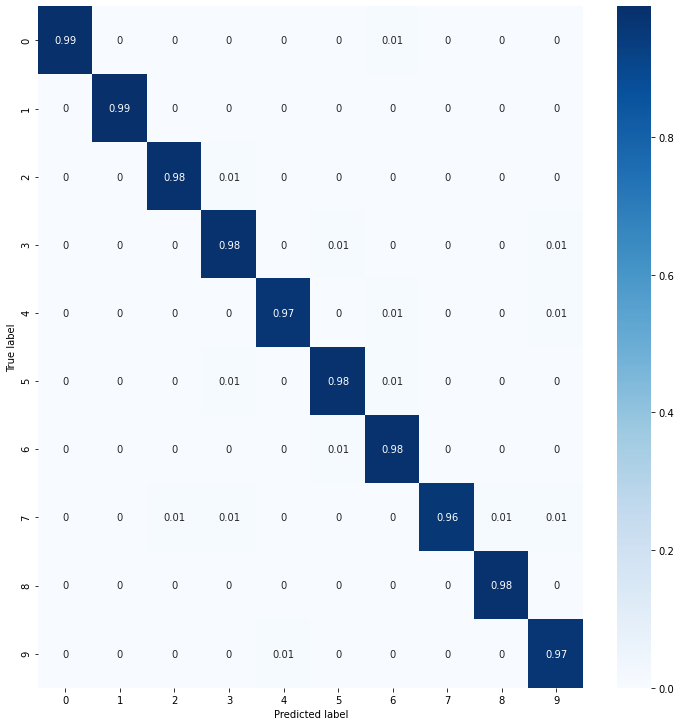

In [81]:
figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#Test di predizione
Col modello addestrato, possiamo usarlo per fare predizioni su alcune immagini.

Con `model.predict(test)` ottengo una previsione su ogni elemento in `test`, per esempio 0.8 sulla classe 0 e 0.2 sulla classe 1.

Con `model.predict_classes(test)` ottengo la classe più probabile per ogni elemento, l'output è del tipo 0 o 1.

In [82]:
predictions = keras_model.predict(test_images)

print("Done")

Done


Qui il modello ha predetto la label per ogni immagine nel testing set.

Guardo la prima predizione:

In [83]:
predictions[0]

array([4.7172318e-08, 4.8773950e-06, 9.1295755e-05, 1.6027152e-03,
       2.8208349e-09, 8.9898722e-06, 2.9905872e-10, 9.9827778e-01,
       1.0634138e-05, 3.5354199e-06], dtype=float32)

La predizione è un array di 10 numeri. Rappresentano la "*confidence*" del modello sulla corrispondenza dell'immagine con ognuno dei 10 differenti label; per vedere la label con cui ha più "*confidence*":

In [84]:
np.argmax(predictions[0])

7

Guardo l'etichetta e vedo se è corretto.

In [85]:
test_labels[0]

7

Costruisco un grafico per guardare meglio alla predizione di più immagini.

Guardo l'immagine 0, la predizione e all'array di predizione.

Previsioni corrette delle labels sono blu e le incorrette sono rosse.

Il numero fornisce la percentuale per la label predetta.

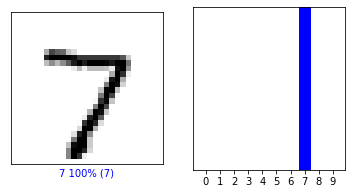

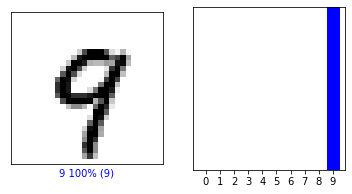

In [86]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Faccio il plot di diverse immagini con le loro predizioni. Il modello può essere sbagliato anche quando molto "confidente".

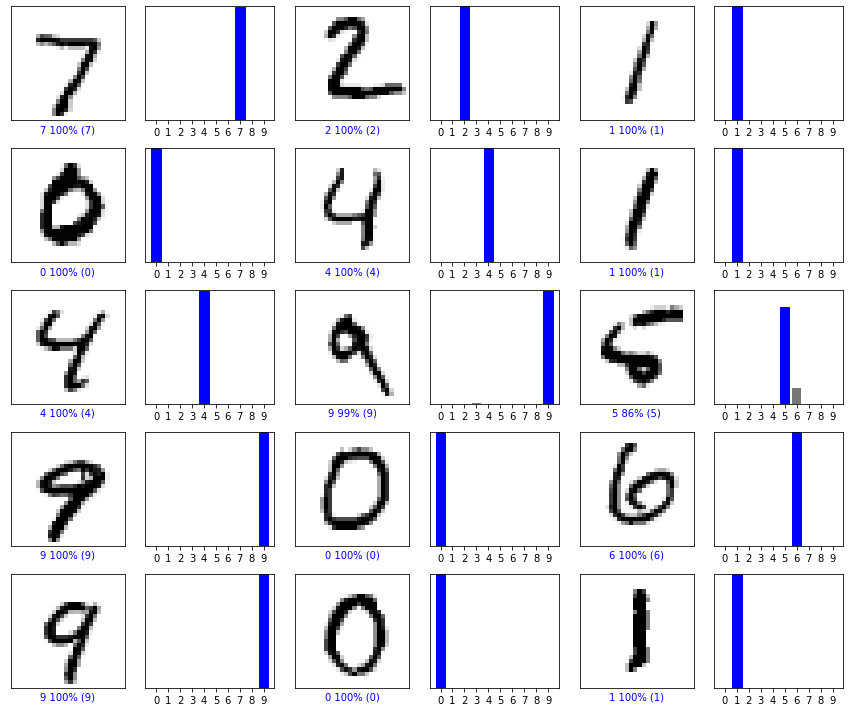

In [87]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Posso poi usare il modello addestrato per fare una predizione su una singola immagine.

In [88]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


Modelli `tf.keras` sono ottimizzati per fare predizioni su *batch*, o collezioni, di esempi alla volta. Pertanto anche se la predizione è su 1 immagine, bisogna aggiungerla ad una lista.

In [89]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


Ora predico la corretta label per questa immagine:

[[1.5211795e-11 1.9776903e-07 9.9999881e-01 2.9204324e-07 8.8215887e-17
  9.5496729e-11 1.6850557e-10 2.4552688e-11 6.7612399e-07 1.3268632e-13]]


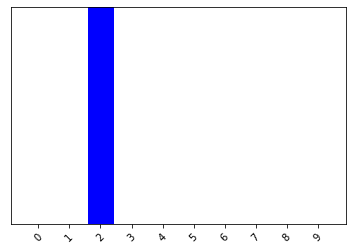

In [92]:
predictions_single = keras_model.predict(img)

print(predictions_single)

plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), classes, rotation=45)

`model.predict` ritorna una lista di liste - una lista per ogni immagine nel batch di dati.

Prendo le predizioni per il nostro batch (di 1 elemento) di dati:

In [91]:
np.argmax(predictions_single[0])

2

Che dovrebbe predirre la label come atteso.